##  SmaStrategy

In [6]:

# Descargar datos de MSFT y guardarlos en un archivo CSV
ticker = "MSFT"
start_date = "2023-01-01"
end_date = "2023-12-31"
msft = yf.Ticker(ticker)
data = msft.history(start=start_date, end=end_date)
csv_file_path = 

data.to_csv(csv_file_path)

# Definición de la clase SmaStrategy para el backtest
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )
    
    def __init__(self):
        self.data_close = self.datas[0].close
        self.order = None
        self.price = None
        self.comm = None
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        
    def next(self):
        if self.order:
            return
        if not self.position:
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

# Cargar datos desde el archivo CSV local para el backtest
data = bt.feeds.GenericCSVData(
    dataname=csv_file_path,
    fromdate=datetime(2023, 1, 1),  # Asegúrate de que estas fechas coincidan con tu archivo CSV
    todate=datetime(2023, 12, 31),
    nullvalue=0.0,
    dtformat=('%Y-%m-%d %H:%M:%S%z'),  # Ajusta esto según el formato de tu CSV
    datetime=0,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5,
    openinterest=-1
)

# Configuración y ejecución del backtest
cerebro = bt.Cerebro(stdstats=False)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

# Ejecuta el backtest y maneja posibles excepciones
try:
    cerebro.run()
    print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
except Exception as e:
    print(f'Error encountered: {e}')


Starting Portfolio Value: 1000.00
2023-01-31, BUY CREATED --- Price: 245.63
2023-02-01, BUY EXECUTED --- Price: 245.82, Cost: 245.82, Commission: 0.00
2023-02-21, SELL CREATED --- Price: 251.08
2023-02-22, OPERATION RESULT --- Gross: 6.67, Net: 6.67
2023-03-14, BUY CREATED --- Price: 259.15
2023-03-15, BUY EXECUTED --- Price: 258.34, Cost: 258.34, Commission: 0.00
2023-04-24, SELL CREATED --- Price: 279.99
2023-04-25, OPERATION RESULT --- Gross: 19.41, Net: 19.41
2023-04-26, BUY CREATED --- Price: 293.51
2023-04-27, BUY EXECUTED --- Price: 294.10, Cost: 294.10, Commission: 0.00
2023-06-26, SELL CREATED --- Price: 327.24
2023-06-27, OPERATION RESULT --- Gross: 36.38, Net: 36.38
2023-06-27, BUY CREATED --- Price: 333.19
2023-06-28, BUY EXECUTED --- Price: 333.28, Cost: 333.28, Commission: 0.00
2023-07-10, SELL CREATED --- Price: 330.46
2023-07-11, OPERATION RESULT --- Gross: -3.59, Net: -3.59
2023-07-12, BUY CREATED --- Price: 335.81
2023-07-13, BUY EXECUTED --- Price: 338.16, Cost: 338.

<IPython.core.display.Javascript object>


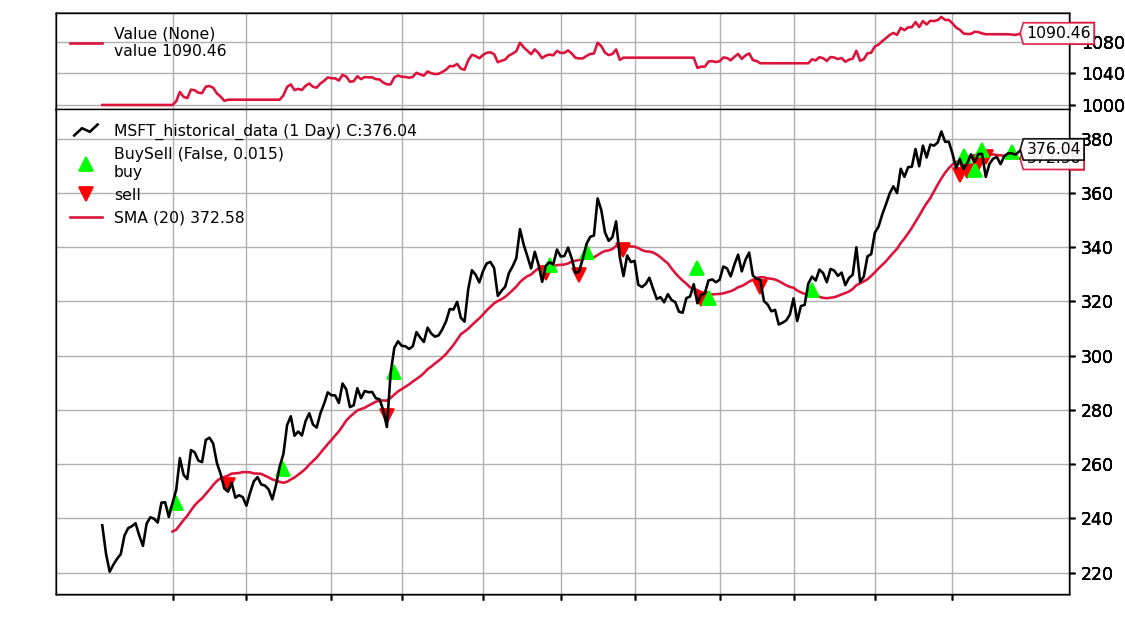

[[<Figure size 900x500 with 2 Axes>]]

In [8]:
import matplotlib.pyplot as plt

# Establece el tamaño del gráfico a un valor más pequeño
plt.rcParams['figure.figsize'] = [9, 5]  # Ancho, Altura en pulgadas
plt.rcParams['figure.dpi'] = 100  # Resolución en DPI (puntos por pulgada)


cerebro.plot(iplot=True, volume=False)

The chart you've provided appears to be a result graph from a trading strategy backtest using the Backtrader library, specifically employing the SmaStrategy. Let's break down what the graph represents:

Black Line (Closing Price):

The black line represents the closing price of Microsoft (MSFT) stock over time. It's the value of the stock at the end of each trading period (which could be daily if the data is daily).
Red Line (SMA - Simple Moving Average):

The red line is the Simple Moving Average (SMA) with a period of 20, as defined in the strategy (ma_period). This indicator smooths out price data to show a longer-term trend.
Green Triangles (Buy Signals):

Each upward green triangle indicates a point where the strategy has generated a buy signal. According to the strategy's logic, this occurs when the closing price is above the SMA value.
Red Triangles (Sell Signals):

Each downward red triangle marks a point where the strategy has issued a sell signal. This happens when the closing price falls below the SMA.
Upper Red Line (Portfolio Value):

The upper red line represents the value of the portfolio or capital over time. It starts with the initial value defined in the code (cerebro.broker.setcash(1000.0)) and fluctuates based on the gains or losses produced by the trading strategy.
The graph illustrates how the SmaStrategy would perform if applied to the MSFT asset during the specified period. The buy and sell signals are generated based on the relationship of the price to the SMA, and the portfolio value reflects the outcome of these trades.

The backtest result, including the final portfolio value, is printed after the backtest execution. In your code, any exception that may occur during the backtest is captured and its error message is printed.